In [1]:
import tvm
from tvm import relay

import numpy as np

from tvm.contrib.download import download_testdata

# PyTorch imports
import torch
import torchvision

In [2]:
model_name = "resnet50"
model = getattr(torchvision.models, model_name)(pretrained=True)
model = model.eval()

# We grab the TorchScripted model via tracing
input_shape = [1, 3, 224, 224]
input_data = torch.randn(input_shape)
scripted_model = torch.jit.trace(model, input_data).eval()

/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


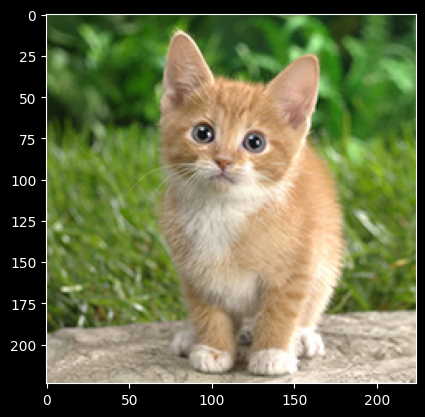

In [3]:
from PIL import Image

img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))

import matplotlib.pyplot as plt

plt.imshow(img)

# Preprocess the image and convert to tensor
from torchvision import transforms

my_preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
img = my_preprocess(img)
img = np.expand_dims(img, 0)

In [4]:
input_name = "input0"
shape_list = [(input_name, img.shape)]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

In [5]:
target = tvm.target.Target("llvm", host="llvm")
dev = tvm.cpu(0)
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [6]:
from tvm.contrib import graph_executor

dtype = "float32"
m = graph_executor.GraphModule(lib["default"](dev))
# Set inputs
m.set_input(input_name, tvm.nd.array(img.astype(dtype)))
# Execute
m.run()
# Get outputs
tvm_output = m.get_output(0)

In [7]:
synset_url = "".join(
    [
        "https://raw.githubusercontent.com/Cadene/",
        "pretrained-models.pytorch/master/data/",
        "imagenet_synsets.txt",
    ]
)
synset_name = "imagenet_synsets.txt"
synset_path = download_testdata(synset_url, synset_name, module="data")
with open(synset_path) as f:
    synsets = f.readlines()

synsets = [x.strip() for x in synsets]
splits = [line.split(" ") for line in synsets]
key_to_classname = {spl[0]: " ".join(spl[1:]) for spl in splits}

class_url = "".join(
    [
        "https://raw.githubusercontent.com/Cadene/",
        "pretrained-models.pytorch/master/data/",
        "imagenet_classes.txt",
    ]
)
class_name = "imagenet_classes.txt"
class_path = download_testdata(class_url, class_name, module="data")
with open(class_path) as f:
    class_id_to_key = f.readlines()

class_id_to_key = [x.strip() for x in class_id_to_key]

# Get top-1 result for TVM
top1_tvm = np.argmax(tvm_output.numpy()[0])
tvm_class_key = class_id_to_key[top1_tvm]

# Convert input to PyTorch variable and get PyTorch result for comparison
with torch.no_grad():
    torch_img = torch.from_numpy(img)
    output = model(torch_img)

    # Get top-1 result for PyTorch
    top1_torch = np.argmax(output.numpy())
    print(top1_torch)
    torch_class_key = class_id_to_key[top1_torch]

print("Relay top-1 id: {}, class name: {}".format(top1_tvm, key_to_classname[tvm_class_key]))
print("Torch top-1 id: {}, class name: {}".format(top1_torch, key_to_classname[torch_class_key]))

282
Relay top-1 id: 282, class name: tiger cat
Torch top-1 id: 282, class name: tiger cat


In [14]:
import numpy as np
import tvm
from tvm import relay
from tvm.relay import testing

from io import BytesIO
import requests
from matplotlib import pyplot as plt
from PIL import Image


In [39]:
def process_image(image):
    image = np.array(image) - np.array([123., 117., 104.])
    image /= np.array([58.395, 57.12, 57.375])
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :]
    return tvm.nd.array(image.astype("float32"))

In [40]:
image_url = 'https://homes.cs.washington.edu/~moreau/media/vta/cat.jpg'
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).resize((224, 224))
image = process_image(image)

In [41]:
def get_calibration_dataset(input_name):
    dataset = []
    for i in range(1):
        data = np.random.uniform(size=(1, 3, 224, 224))
        dataset.append({input_name: data})
    return dataset

def get_cpu_runtime(mod, params):
    func = mod['main']

    target = 'llvm'
    ctx = tvm.device(target)

    with relay.build_config(opt_level=3):
        graph, lib, params = relay.build_module.build(func, target=target, params=params)
    runtime =  tvm.contrib.graph_executor.create(graph, lib, ctx)
    runtime.set_input(**params)

    return runtime

global_scale=8.0,
                                nbit_input=8,
                                nbit_weight=8,
                                nbit_activation=activation_bit,
                                dtype_input='int8',
                                dtype_weight='int8',
                                dtype_activation='int' + str(activation_bit)

In [53]:
def quantize_calibrate(relay_ir, params, dataset, out_bits):
    print("Quantize calibration....")
    with relay.quantize.qconfig(global_scale=8.0,
                                nbit_input=8,
                                nbit_weight=8,
                                nbit_activation=out_bits,
                                dtype_input='int8',
                                dtype_weight='int8',
                                dtype_activation='int' + str(out_bits)):
        relay_ir = relay.quantize.quantize(relay_ir, params, dataset=dataset)

    return relay_ir

In [43]:
def run_inference(runtime, batch):
    runtime.set_input(**batch)
    runtime.run()
    return runtime.get_output(0).asnumpy()

In [52]:
def test_cpu_quantization():
    # Get cpu runtime
    mod, params = testing.resnet.get_workload(num_layers=18)
    batch = get_calibration_dataset("data")
    cpu_runtime = get_cpu_runtime(mod, params)
    
    # Get quantized cpu runtime (int32 output dtype)
    mod, params = testing.resnet.get_workload(num_layers=18)
    batch = get_calibration_dataset("data")
    mod = quantize_calibrate(mod, params, batch, out_bits=32)
    cpu_runtime_q32 = get_cpu_runtime(mod, params)

    # Get quantized cpu runtime (int8 output dtype)
    mod, params = testing.resnet.get_workload(num_layers=18)
    batch = get_calibration_dataset("data")
    mod = quantize_calibrate(mod, params, batch, out_bits=8)
    cpu_runtime_q8 = get_cpu_runtime(mod, params)

    # Run inferences
    cpu_outputs = run_inference(cpu_runtime, {"data": image})
    cpu_outputs_q32 = run_inference(cpu_runtime_q32, {"data": image})
    cpu_outputs_q8 = run_inference(cpu_runtime_q8, {"data": image})

    print("CPU (float32 out):", np.argmax(cpu_outputs), cpu_outputs.max())
    print("CPU (int32 out):", np.argmax(cpu_outputs_q32), cpu_outputs_q32.max())
    print("CPU (int8 out):", np.argmax(cpu_outputs_q8), cpu_outputs_q8.max())

In [54]:
if __name__ == "__main__":
    test_cpu_quantization()

/tmp/ipykernel_692840/1242572578.py:15: DeprecationWarning: legacy graph executor behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_executor.GraphModule for the  new recommended usage.
  graph, lib, params = relay.build_module.build(func, target=target, params=params)


Quantize calibration....
Quantize calibration....
CPU (float32 out): 135 0.001406128
CPU (int32 out): 135 0.0013020462
CPU (int8 out): 0 0.001


In [57]:
mod, params = testing.resnet.get_workload(num_layers=50)
batch = get_calibration_dataset("data")
mod = quantize_calibrate(mod, params, batch, out_bits=32)
cpu_runtime_q8 = get_cpu_runtime(mod, params)
cpu_outputs_q8 = run_inference(cpu_runtime_q8, {"data": image})
print("CPU (int8 out):", np.argmax(cpu_outputs_q8), cpu_outputs_q8.max())

mod, params = testing.resnet.get_workload(num_layers=50)
batch = get_calibration_dataset("data")
mod = quantize_calibrate(mod, params, batch, out_bits=16)
cpu_runtime_q8 = get_cpu_runtime(mod, params)
cpu_outputs_q8 = run_inference(cpu_runtime_q8, {"data": image})
print("CPU (int8 out):", np.argmax(cpu_outputs_q8), cpu_outputs_q8.max())

batch = get_calibration_dataset("data")
mod = quantize_calibrate(mod, params, batch, out_bits=8)
cpu_runtime_q8 = get_cpu_runtime(mod, params)
cpu_outputs_q8 = run_inference(cpu_runtime_q8, {"data": image})
print("CPU (int8 out):", np.argmax(cpu_outputs_q8), cpu_outputs_q8.max())

Quantize calibration....


/tmp/ipykernel_692840/1242572578.py:15: DeprecationWarning: legacy graph executor behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_executor.GraphModule for the  new recommended usage.
  graph, lib, params = relay.build_module.build(func, target=target, params=params)


CPU (int8 out): 694 0.0011495966
Quantize calibration....
CPU (int8 out): 694 0.0011495966
Quantize calibration....


InternalError: Traceback (most recent call last):
  13: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::transform::Pass, tvm::IRModule)>::AssignTypedLambda<tvm::transform::{lambda(tvm::transform::Pass, tvm::IRModule)#7}>(tvm::transform::{lambda(tvm::transform::Pass, tvm::IRModule)#7}, std::string)::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)
  12: tvm::transform::Pass::operator()(tvm::IRModule) const
  11: tvm::transform::Pass::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  10: tvm::transform::SequentialNode::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  9: tvm::transform::Pass::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  8: tvm::relay::transform::FunctionPassNode::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  7: tvm::transform::Pass::operator()(tvm::IRModule) const
  6: tvm::transform::Pass::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  5: tvm::transform::ModulePassNode::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
  4: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::IRModule, tvm::transform::PassContext)>::AssignTypedLambda<tvm::relay::transform::InferType()::{lambda(tvm::IRModule, tvm::transform::PassContext const&)#1}>(tvm::relay::transform::InferType()::{lambda(tvm::IRModule, tvm::transform::PassContext const&)#1})::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)
  3: tvm::relay::TypeInferencer::Infer(tvm::GlobalVar, tvm::relay::Function)
  2: tvm::relay::TypeSolver::Solve()
  1: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<bool (tvm::runtime::Array<tvm::Type, void> const&, int, tvm::Attrs const&, tvm::TypeReporter const&)>::AssignTypedLambda<bool (*)(tvm::runtime::Array<tvm::Type, void> const&, int, tvm::Attrs const&, tvm::TypeReporter const&)>(bool (*)(tvm::runtime::Array<tvm::Type, void> const&, int, tvm::Attrs const&, tvm::TypeReporter const&))::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)
  0: tvm::relay::quantize::SimulatedQuantizeRel(tvm::runtime::Array<tvm::Type, void> const&, int, tvm::Attrs const&, tvm::TypeReporter const&)
  File "/workspace/tvm/src/relay/quantize/quantize.cc", line 52
InternalError: Check failed: data->shape.size() != 0 (0 vs. 0) : Input shape cannot be empty